<div style="width:90%; text-align:center; border-width: 0px; display:block; margin-left:auto; margin-right:auto; background-color:off white; position: relative;">
  <div class="alert alert-block alert-success" style="text-align:center; color:white; background-color:#1e2124 !important;">
    <img src="https://raw.githubusercontent.com/monnomero/IA-para-fisica/main/Imagens/logo_unb.png" style="width: 200px; opacity:0.85;">
    <h1>Universidade de Brasília</h1>
    <h2>Instituto de Física</h2>
    <hr style="width:44%;border:1px solid white;">
    <h3>Mini Curso de Inteligência Artificial para a Física</h3> 
    <h4>Henrique de Oliveira Noronha</h4>
    <hr style="width:44%;border:1px solid white;">
  </div>
  <img src="https://raw.githubusercontent.com/monnomero/IA-para-fisica/main/Imagens/logo_if.png" style="position: absolute; bottom: 20px; left: 40px; width: 100px;">
</div>


# **➲ Aula 3 - Redes Neurais Informadas pela Física (PINNs)**

## ➥ Teorema da Aproximação Universal 

Um resultado bem famoso na análise matemática das redes neurais é que redes neurais densas com ativações não polinomiais, têm o poder de representar qualquer função contínua para qualquer grau de precisão. Por exemplo, dado um número de parâmetros suficiente, conseguimos aproximar qualquer solução contínua de uma equação diferencial com redes neurais densas com função de ativação tanh. *(Multilayer Feedforward Networks with Non-Polynomial Activation Functions Can Approximate Any Function, Moshe Leshno et.al)*

Esse teorema é essencial para garantir que podemos usar redes neurais para obter soluções adequadas para problemas físicos, que em sua grande maioria, são contínuas. Esse teorema foi extendido para funções discontínuas *(A three layer neural network can represent any multivariate function, Vugar Ismailov)*. Porém a arquitetura necessária se torna mais complexa e não é o foco nesse curso. Para uma aplicação em soluções discontínuas, veja o artigo de Ziming Liu, et.al *(KAN: Kolmogorov–Arnold Networks)*

## ➥ PINNs para Previsão

Até agora, vimos somente arquiteturas de redes neurais em que a função de perda busca minimizar a diferença da saída do modelo com as saídas dadas. Com isso, esperamos que o modelo consiga generalizar para entradas desconhecidas. Porém essa abordagem é um pouco inocente, e não muito rigorosa, pois faz com que nosso modelo ignore princípios físicos elementares, como a conservação de energia em sistemas conservativos. Além disso, se nosso sistema de série temporal, por exemplo, não tiver um caráter oscilatório óbvio, o modelo dificilmente conseguirá ser representativo para um tempo maior do que o máximo informado.

Vamos exemplificar essa última afimação com um exemplo, treinaremos um modelo para aprender uma solução do lançamento balístico com atrito, a partir do tempo. Isto é, a entrada é um momento temporal, e a saída é a posição do projétil. Por exemplo, inserindo t = 0.0, teríamos como saída a posição [0.0,0.0] que é de onde o projétil sai. Contudo, o treinamento será feito somente com 25 dados aleatórios de metade do tempo total da solução para trás. Seguem os resultados:

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/monnomero/IA-para-fisica/main/Imagens/Dados_balistico_PINN.png" alt="RNN" width="500">
  <img src="https://raw.githubusercontent.com/monnomero/IA-para-fisica/main/Imagens/Previsao_balistico_PINN.png" alt="RNN" width="500">
</div>

Como é possível observar, após o tempo contendo o último dado de treinamento observado, o modelo começa a "alucinar" e converge para uma posição totalmente sem sentido físico.

Temos ainda um outro problema, se a quantidade de dados que tivermos não for suficiente para o modelo aprender, teremos um péssimo resultado. Por exemplo, se por algumo motivo só tivermos os seguintes pontos em um movimento oscilatório:

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/monnomero/IA-para-fisica/main/Imagens/Dados_oscilatorio_PINN.png" alt="RNN" width="500">
</div>

Então, ao treinar um modelo nesses pontos da mesma forma que acima, teremos o resultado totalmente insatisfatório a seguir:

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/monnomero/IA-para-fisica/main/Imagens/Previsao_oscilatorio_PINN.png" alt="RNN" width="500">
</div>

Perceba que a curva da previsão do modelo passa direitinho nos pontos de treinamento, porém, a trajetória como um todo não é uma boa previsão. 

Então o que podemos fazer para melhorar esses casos. Podemos fazer o modelo minimizar a diferença dos aspectos físicos de suas saídas com o esperado fisicamente. Por exemplo, podemos incorporar na função de erro um termo que minimiza a diferença de energia do sistema para a energia esperada, fazendo com que o modelo tenda a aprender soluções que conservam a energia. De fato essa é uma maneira de incorporar a física nas redes neurais, porém a forma mais comum é a de adicionar um termo na função de perda que faça o modelo obedecer a EDP do sistema e possivelmente outro que faça ele obedecer às condições de contorno do problema. 

Agora a questão é, como fazemos isso? Imagine que tenhamos uma EDO linear de segunda ordem que represente a situação física dos dados que temos do tipo:

\begin{equation*}
      f(x,t)\frac{d²x}{dt²} + g(x,t)\frac{dx}{dt} + h(x,t) = 0 
\end{equation*}

Onde t é o tempo. Vamos fazer um esboço de como treinar uma PINN que tenha como input a variável independente t e como saída a solução específica x dos dados que temos. Primeiramente fazemos um tensor que representa o espaço, ou o tempo ou ambos que queremos que nossa solução seja fisicamente viável. Nesse caso faremos um tensor com pontos temporais, por exemplo, de 0 a 10 segundos com intervalos de 0.1 segundos, esse será o tensor de entrada de treinamento físico. Então faremos um loop de treinamento que consiste nos seguintes passos:

1. Fazer a função de perda que minimiza a saída do modelo com a saída de treinamento, como padrão, utilizando MSE, ou MAE.
2. Fazer o modelo prever as saídas do nosso tensor de treinamento físico, que chamaremos de saída física, que nesse caso é nosso x da EDO.
3. Pegar os gradientes de x com relação às entradas de treinamento físico da mesma forma que fizemos na primeira aula, que nos dará $\frac{dx}{dt}$ e $\frac{d²x}{dt²}$
4. Fazer uma função de perda, com MSE ou MAE da nossa EDO utilizando os gradientes, a saída física x e nossos gradientes do passo passado.
5. Juntar as duas funções de perda em uma soma: $Perda_{total} = Perda_{dados} + k*Perda_{EDO}$, onde o fator multiplicativo k é outro parâmetro que é bem tentativa e erro, mas no geral é por volta de 1.0 a 0.001
6. Pegar os gradientes da perda total em relação aos parâmetros do modelo 
7. Minimizar essa função de perda total utilizando os gradientes do passo 6 com um otimizador de sua escolha, porém utilizaremos o ADAM

Vamos fazer um exemplo para ficar mais fácil com o oscilador harmônico da mesma forma que o exemplo acima:


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

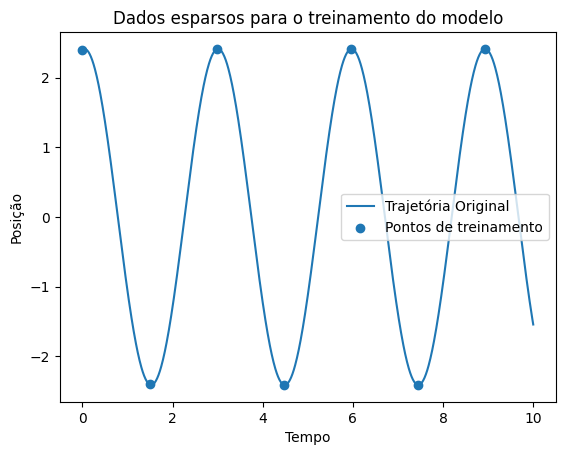

In [ ]:
# Definir a função para resolver com ode int
def oscilador_harmonico(y,t,k,m):
    x = y[0]
    v = y[1]
    dvdt = -k/m*x
    return [v,dvdt]

# Fixar semente para obter mesmos resultados
np.random.seed(42)
condicoes_iniciais = [2.4,0.5]
dt = 0.01
t = np.arange(0,10+dt,dt)
k = 4.5
m = 1.0
solucao = odeint(oscilador_harmonico, condicoes_iniciais, t, args=(k,m))[:,0]

n = 149
pontos_de_treinamento = [i*n for i in range(7)]


plt.title("Dados esparsos para o treinamento do modelo")
plt.plot(t,solucao,label="Trajetória Original")
plt.scatter(t[pontos_de_treinamento],solucao[pontos_de_treinamento],label="Pontos de treinamento")
plt.xlabel("Tempo")
plt.ylabel("Posição")
plt.legend()
plt.plot()

entradas_treinamento = t[pontos_de_treinamento].reshape(-1,1)
saidas_treinamento = solucao[pontos_de_treinamento].reshape(-1,1)

entradas_treinamento = tf.cast(entradas_treinamento,dtype=tf.float32) # Converte para tensor para não dar problema de mismatch de tipo nos cálculos
saidas_treinamento = tf.cast(saidas_treinamento,dtype=tf.float32) # Converte para tensor para não dar problema de mismatch de tipo nos cálculos


entradas_treinamento_fisico = tf.convert_to_tensor(t[:-1:10].reshape(-1,1),dtype=tf.float32) # Nossas entradas utilizadas para manter a física serão justamente o tempo t da solução "completa". 
# Estamos impondo então que nossa solução faça sentido físico nesse tempo, até 10 segundos, mais do que isso não temos garantia.



In [14]:
modelo = Sequential([Input((1,)),
                     Dense(64,activation="tanh"),
                     Dense(64,activation="tanh"),
                     Dense(1,activation="linear")])
modelo.summary()
#Não vamos compilar o modelo pois vamos definir um loop de treinamento próprio

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#Definiremos a função do loop de treinamento aqui
k_fisica = 5e-1 # Multiplicador da perda física
taxa_de_aprendizado = 0.0005
otimizador = Adam(learning_rate=taxa_de_aprendizado)
@tf.function # Isso acelera a função
def loop_treinamento_PINN(entradas,saidas,x_fis): #entradas e saídas são as que damos para o modelo e x_fis é o tensor de entradas de treinamento físico
    with tf.GradientTape() as tape: # Fita responsável por pegar os gradientes da perda em relação ao modelo
        perda_normal = tf.reduce_mean(tf.square(modelo(entradas)-saidas)) # MSE padrão das saídas do modelo com as saídas dadas
        with tf.GradientTape() as t1:
            t1.watch(x_fis)
            with tf.GradientTape() as t2:
                t2.watch(x_fis)
                x = modelo(x_fis) # Posição do oscilador
            dxdt = t2.gradient(x,x_fis) # Velocidade do oscilador 
        d2xdt2 = t1.gradient(dxdt,x_fis) # Aceleração do oscilador
        perda_fisica = k_fisica*tf.reduce_mean(tf.square(d2xdt2+k/m*x)) # EDO do oscilador harmônico que era para dar zero, ou seja, ao minimizarmos esse termo, tornaremos as saídas do modelo mais condizentes com a física
        perda_total = perda_normal + perda_fisica
    gradientes_modelo = tape.gradient(perda_total,modelo.trainable_variables)
    otimizador.apply_gradients(zip(gradientes_modelo,modelo.trainable_variables)) # Dá os gradientes para o otimizador ADAM minimizar a perda
    return perda_fisica, perda_normal, perda_total

In [16]:
epochs = 20000

for epoch in range(epochs+1):
    fisica,normal,total = loop_treinamento_PINN(entradas_treinamento,saidas_treinamento,entradas_treinamento_fisico)
    if (epoch)%500 == 0:
        tf.print(epoch,fisica,normal,total)
 

0 4.357337 5.9566 10.3139372
500 0.0927001089 5.44766235 5.54036236
1000 0.170875981 5.08972073 5.26059675
1500 0.325343132 4.23154306 4.5568862
2000 0.4381347 3.53323531 3.97137
2500 0.345449 2.32227945 2.66772842
3000 0.419475645 1.58432758 2.00380325
3500 0.423417807 0.882092595 1.3055104
4000 0.0961554125 0.188555703 0.284711123
4500 0.0319589414 0.0174206 0.0493795425
5000 0.0136264609 0.00283430307 0.0164607633
5500 0.00529848738 0.000504515774 0.00580300298
6000 0.00220252573 9.67252e-05 0.00229925103
6500 0.00121980207 2.26052198e-05 0.00124240725
7000 0.000888590293 9.92559944e-06 0.000898515922
7500 0.000946347544 2.15889559e-05 0.000967936474
8000 0.000788833946 1.97181907e-05 0.00080855214
8500 0.000516267086 4.97905e-06 0.000521246111
9000 0.000971841393 4.14834903e-05 0.00101332483
9500 0.000420607714 3.41579175e-06 0.000424023514
10000 0.000842097448 4.06060753e-05 0.00088270352
10500 0.000331858551 1.88150534e-06 0.000333740056
11000 0.000376475335 9.44638759e-06 0.0003

[]

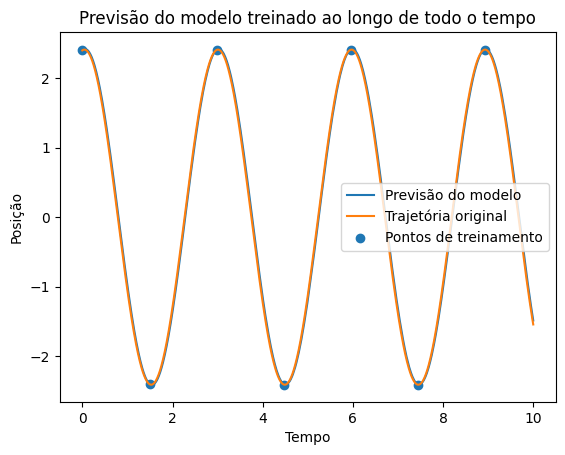

In [24]:
previsao = modelo(t)


plt.title("Previsão do modelo treinado ao longo de todo o tempo")
plt.plot(t,previsao,label="Previsão do modelo")
plt.plot(t,solucao,label="Trajetória original")
plt.scatter(t[pontos_de_treinamento],solucao[pontos_de_treinamento],label="Pontos de treinamento")
plt.xlabel("Tempo")
plt.ylabel("Posição")
plt.legend()
plt.plot()

Como podemos observar acima, o modelo conseguiu aprender muito melhor a solução do problema com o mesmo número de pontos observados, somente por informar ao modelo a EDO que rege o sistema. Claro que esse é um caso extremamente simples, vamos agora testar em uma solução mais complicada, a do pêndulo simples com um termo dissipativo proporcional à velocidade:

Temos então que a EDO do sistema é:

\begin{equation*}
\frac{d²\theta}{dt²} + \frac{g}{L}sin(\theta) + k\frac{d\theta}{dt} = 0
\end{equation*}

Vamos gerar uma condição inicial de forma que o pêndulo realize algumas voltas completas e depois passe a oscilar como um oscilador amortecido:

<div style="text-align: center;">
  <video src=https://raw.githubusercontent.com/monnomero/IA-para-fisica/main/Videos/pendulo.mp4 width="520" height="440" controls></video> 
</div>

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

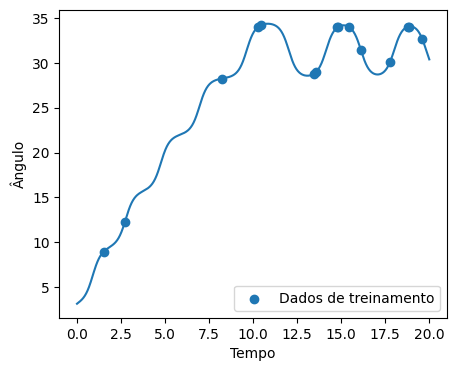

In [3]:
# Definir a função para resolver com ode int
def pendulo_simples(y,t,g,L,k):
    theta = y[0]
    omega = y[1]
    domega_dt = -g/L*np.sin(theta)-k*omega
    return [omega,domega_dt]
# Fixar semente para obter mesmos resultados
np.random.seed(42)
condicoes_iniciais = [np.pi,1.5]
dt = 0.02
t = np.arange(0,20+dt,dt)
L = 1.0
k = 0.01
g = 9.81
solucao = odeint(pendulo_simples, condicoes_iniciais, t, args=(g,L,k))[:,0] # Pegar só os ângulos da solução

indices = np.random.choice(np.arange(0,len(solucao)),15,replace=False)
entradas_treinamento = t[indices].reshape(-1,1)
saidas_treinamento = solucao[indices].reshape(-1,1)

entradas_treinamento = tf.cast(entradas_treinamento,dtype=tf.float32) # Converte para tensor para não dar problema de mismatch de tipo nos cálculos
saidas_treinamento = tf.cast(saidas_treinamento,dtype=tf.float32)  # Converte para tensor para não dar problema de mismatch de tipo nos cálculos

entradas_treinamento_fisico = tf.convert_to_tensor(t[:-1:10].reshape(-1,1),dtype=tf.float32) # Preparar a entrada de treinamento física que consiste em 10% do tempo separado homogeneamente

plt.figure(figsize=(5,4))
plt.plot(t,solucao)
plt.scatter(entradas_treinamento,saidas_treinamento,label="Dados de treinamento")
plt.legend()
plt.xlabel("Tempo")
plt.ylabel("Ângulo")
plt.show()

In [75]:
modelo = Sequential([Input((1,)),
                     Dense(64,activation="tanh"),
                     Dense(64,activation="tanh"),
                     Dense(1,activation="linear")])
#Não vamos compilar o modelo pois vamos definir um loop de treinamento próprio

In [76]:
#Definiremos a função do loop de treinamento aqui
k_fisica = 1e-3 # Multiplicador da perda física
taxa_de_aprendizado = 0.0001
otimizador = Adam(learning_rate=taxa_de_aprendizado)
@tf.function # Isso acelera a função
def loop_treinamento_PINN(entradas,saidas,x_fis): #entradas e saídas são as que damos para o modelo e x_fis é o tensor de entradas de treinamento físico
    with tf.GradientTape() as tape: # Fita responsável por pegar os gradientes da perda em relação ao modelo
        perda_normal = tf.reduce_mean(tf.square(modelo(entradas)-saidas)) # MSE padrão das saídas do modelo com as saídas dadas
        with tf.GradientTape() as t1:
            t1.watch(x_fis)
            with tf.GradientTape() as t2:
                t2.watch(x_fis)
                theta = modelo(x_fis) # Ângulo do pêndulo
            omega = t2.gradient(theta,x_fis) # Velocidade angular do pêndulo 
        domegadt = t1.gradient(omega,x_fis) # Aceleração angular do pêndulo
        perda_fisica = k_fisica*tf.reduce_mean(tf.square(domegadt+g/L*tf.math.sin(theta)+k*omega)) # EDO do pêndulo, note que temos que usar tf.math.sin
        perda_total = perda_normal + perda_fisica
    gradientes_modelo = tape.gradient(perda_total,modelo.trainable_variables)
    otimizador.apply_gradients(zip(gradientes_modelo,modelo.trainable_variables)) # Dá os gradientes para o otimizador ADAM minimizar a perda
    return perda_fisica, perda_normal, perda_total

In [ ]:
epochs = 50000

for epoch in range(epochs+1):
    fisica,normal,total = loop_treinamento_PINN(entradas_treinamento,saidas_treinamento,entradas_treinamento_fisico)
    if (epoch)%500 == 0:
        tf.print(epoch,fisica,normal,total)
 

[]

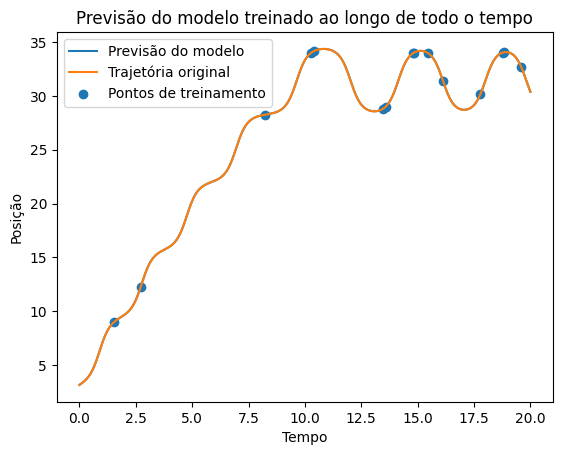

In [ ]:
previsao = modelo(t)


plt.title("Previsão do modelo treinado ao longo de todo o tempo")
plt.plot(t,previsao,label="Previsão do modelo")
plt.plot(t,solucao,label="Trajetória original")
plt.scatter(t[indices],solucao[indices],label="Pontos de treinamento")
plt.xlabel("Tempo")
plt.ylabel("Posição")
plt.legend()
plt.plot()

Outro resultado com sucesso, observe que dessa vez a constante k_fisica diminuiu de 0.1 para 0.001, essa escolha foi feita a partir de tentativa e erro e quase sempre vai mudar para diferentes sistemas. Agora que já entendemos a capacidade de previsão das PINNs para EDOs, vamos explorar outra capacidade muito interessante: a de resolver problemas inversos 

## ➥ PINNs para Problemas Inversos

Primeiramente vamos esclarescer o que é um problema inverso. Imagine que você tenha dados de um oscilador harmônico com amortecimento e com um forçamento senoidal, porém não saiba as constantes do problema. O problema inverso é justamente obter essas constantes desconhecidas.

Podemos criar uma PINN para resolver esse problema ao acrescentar variáveis treináveis no loop de treinamento e utilizar seus gradientes em relação à função de perda para ir atualizando os valores das variáveis. Ou seja, treinamos o modelo para levar em consideração a EDO do sistema e treinamos as variáveis que possivelmente estão na EDO para fazer sentido com os dados que damos para o treinamento. Vamos logo partir para os exemplos que fica bem mais fácil de entender.

Primeiramente vamos fazer o exemplo do oscilador amortecido e forçado de EDO:

\begin{equation*}
    \frac{d²x}{dt²} + 2\zeta\omega_0\frac{dx}{dt} +  \omega_0²x - Fcos(\omega_0t) = 0
\end{equation*}

Onde queremos obter as constantes $\zeta$, $\omega_0$ e F.

In [32]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from scipy.integrate import odeint 

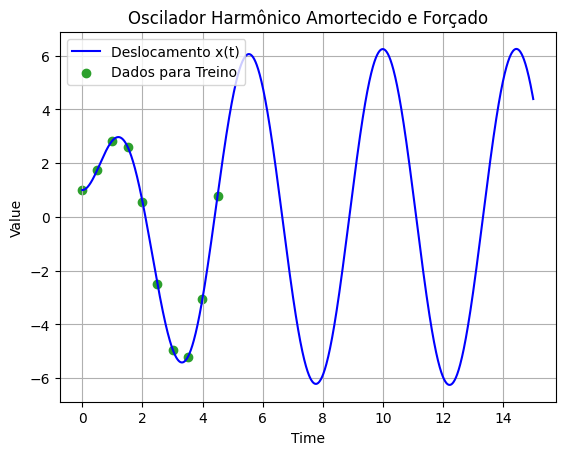

In [100]:
#Função 
def oscilador_forcado_amortecido(y, t, zeta, omega_0, F0):
    x = y[0]
    v = y[1]
    dydt = [v, -2 * zeta * omega_0 * v - omega_0**2 * x + F0*np.cos(omega_0*t)]
    return dydt

# Fixar semente para obter mesmos resultados
np.random.seed(42)
# Parametros
zeta = 0.4    #Taxa de amortecimento
k = 2.0  # Constante da mola
m = 1.0 # Massa
omega_0 = np.sqrt(k*m)    # Frequência natural
y0 = [1.0,  0.0]   # Condições iniciais
F0 = 10.0

dt = 0.01
t = np.arange(0, 15+dt, dt)  
entradas_treinamento_fisico = tf.convert_to_tensor(t.reshape(-1,1),dtype=tf.float32)

solucao = odeint(oscilador_forcado_amortecido, y0, t, args=(zeta, omega_0, F0))[:,0]



# Dados para treinar a rede  (Uma amostra a cada 20 pontos até o 200)
entradas_treinamento = t[:500:50].reshape(-1,1)
saidas_treinamento = solucao[:500:50].reshape(-1,1)
#Vamos colocar um leve ruido gaussiano para parecer mais dados físicos
entradas_treinamento = entradas_treinamento + np.random.normal(size=entradas_treinamento.shape, scale = 0.005*np.abs(entradas_treinamento))
saidas_treinamento = saidas_treinamento + np.random.normal(size=saidas_treinamento.shape, scale = 0.005*np.abs(saidas_treinamento))

entradas_treinamento = tf.cast(entradas_treinamento,dtype=tf.float32) # Converte para tensor para não dar problema de mismatch de tipo nos cálculos
saidas_treinamento = tf.cast(saidas_treinamento,dtype=tf.float32)  # Converte para tensor para não dar problema de mismatch de tipo nos cálculos



plt.figure()
plt.plot(t, solucao, 'b-', label='Deslocamento x(t)')
plt.scatter(entradas_treinamento, saidas_treinamento, color="tab:green", label="Dados para Treino")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='best')
plt.title('Oscilador Harmônico Amortecido e Forçado')
plt.grid()
plt.show()

**Agora vamos definir os parâmetros que queremos descobrir em forma de tf.Variable com a especificação trainable=True, todas com um chute inicial de 0.1**

In [101]:
F0_treinavel = tf.Variable(0.1,trainable=True)
zeta_treinavel = tf.Variable(0.1,trainable=True)
omega_0_treinavel = tf.Variable(0.1,trainable=True)

In [102]:
modelo = Sequential([Input((1,)),
                     Dense(64,activation="tanh"),
                     Dense(64,activation="tanh"),
                     Dense(1,activation="linear")])
#Não vamos compilar o modelo pois vamos definir um loop de treinamento próprio

In [103]:
taxa_de_aprendizado =0.001
otimizador = Adam(learning_rate=taxa_de_aprendizado)
k_fisica=(1e-1) 

@tf.function # Isso acelera a função
def loop_treinamento_PINN(entradas,saidas,x_fis): #entradas e saídas são as que damos para o modelo e x_fis é o tensor de entradas de treinamento físico
    with tf.GradientTape() as tape: # Fita responsável por pegar os gradientes da perda em relação ao modelo
        perda_normal = tf.reduce_mean(tf.square(modelo(entradas)-saidas)) # MSE padrão das saídas do modelo com as saídas dadas
        with tf.GradientTape() as t1:
            t1.watch(x_fis)
            with tf.GradientTape() as t2:
                t2.watch(x_fis)
                x = modelo(x_fis) # Posição
            v = t2.gradient(x,x_fis) # Velocidade 
        dvdt = t1.gradient(v,x_fis) # Aceleração 
        #EDO do oscilador harmonico forçado, note que temos que usar nossas variaveis treinaveis e como x_fis nesse caso são nossos tempos, é ele que colocamos no cosseno
        EDO_oscilador = dvdt + 2*zeta_treinavel*omega_0_treinavel*v + omega_0_treinavel**2*x - F0_treinavel*tf.cos(omega_0_treinavel*x_fis)
        perda_fisica = k_fisica*tf.reduce_mean(tf.square(EDO_oscilador)) 
        perda_total = perda_normal + perda_fisica
    variaveis_treinaveis = [omega_0_treinavel,zeta_treinavel,F0_treinavel]
    #OBS: AS VARIÁVEIS TREINÁVEIS TÊM QUE VIR PRIMEIRO NOS GRADIENTES E NO OTIMIZADOR
    gradientes_modelo = tape.gradient(perda_total,variaveis_treinaveis+modelo.trainable_variables) # Juntamos as variáveis treinaveis do modelo com as nossas variáveis do sistema em uma lista para obter os gradientes
    otimizador.apply_gradients(zip(gradientes_modelo,variaveis_treinaveis+modelo.trainable_variables)) # Dá os gradientes para o otimizador ADAM minimizar a perda e minimizar a disparidade das nossas variáveis treinaveis
    return perda_fisica, perda_normal, perda_total


Vamos treinar por 100000 epochs, que é um número relativamente alto e talvez demore bastante dependendo do seu setup, mas a introdução de mais variáveis desconhecidas aumenta muito a dificuldade do modelo aprender, pois acaba virando um grande cabo de guerra entre o modelo tentando minimizar a diferença dos dados, da física e de levar em consideração essas variáveis.

In [104]:
epochs = 100000

for epoch in range(epochs+1):
    fisica,normal,total = loop_treinamento_PINN(entradas_treinamento,saidas_treinamento,entradas_treinamento_fisico)
    if (epoch)%500 == 0:
        tf.print(epoch,fisica,normal,total)
    if (epoch+1)%5000 == 0:
        tf.print(omega_0_treinavel,zeta_treinavel,F0_treinavel)
 

0 0.000385680469 7.3266511 7.32703686
500 0.494056314 0.268262446 0.76231873
1000 0.225029334 0.0691168755 0.29414621
1500 0.214406118 0.0624753721 0.276881486
2000 0.181879431 0.0571983047 0.239077732
2500 0.165527478 0.0496227816 0.215150267
3000 0.148147315 0.0478998907 0.196047202
3500 0.132872805 0.0463784859 0.179251283
4000 0.126995862 0.0450216457 0.172017515
4500 0.124590531 0.044787854 0.169378385
1.36201489 -0.0610917583 -1.13872802
5000 0.124008298 0.0443859063 0.168394208
5500 0.122612476 0.0445165969 0.16712907
6000 0.121248595 0.0440617763 0.165310368
6500 0.118748344 0.0438804105 0.162628755
7000 0.116076782 0.0434107594 0.159487545
7500 0.114629053 0.0437333211 0.158362374
8000 0.113971405 0.0434008613 0.157372266
8500 0.113621831 0.0430197828 0.156641617
9000 0.112934411 0.0429075956 0.155842
9500 0.112050734 0.0430295244 0.155080259
1.37902653 -0.0680970624 -1.20720279
10000 0.11178565 0.0428252518 0.154610902
10500 0.111205079 0.0431810804 0.154386163
11000 0.110548

Omega Previsto: 1.41343, Zeta Previsto: 0.44448, F0 Previsto: 10.62663
Omega Original: 1.41421, Zeta Original: 0.40000, F0 Original: 10.00000


[]

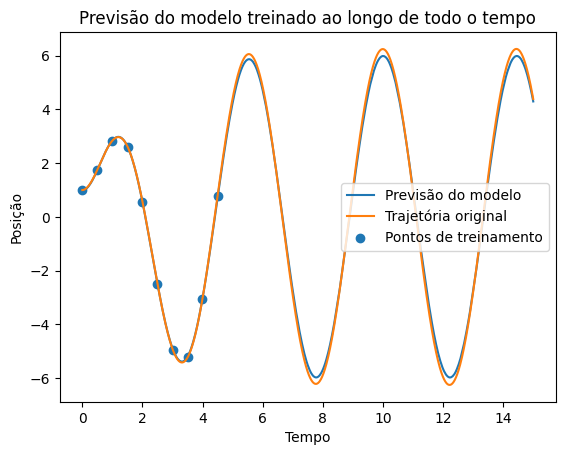

In [105]:
previsao = modelo(t)

tf.print(f"Omega Previsto: {float(omega_0_treinavel):.5f}, Zeta Previsto: {float(zeta_treinavel):.5f}, F0 Previsto: {float(F0_treinavel):.5f}")
print(f"Omega Original: {omega_0:.5f}, Zeta Original: {zeta:.5f}, F0 Original: {F0:.5f}")
plt.title("Previsão do modelo treinado ao longo de todo o tempo")
plt.plot(t,previsao,label="Previsão do modelo")
plt.plot(t,solucao,label="Trajetória original")
plt.scatter(entradas_treinamento,saidas_treinamento,label="Pontos de treinamento")
plt.xlabel("Tempo")
plt.ylabel("Posição")
plt.legend()
plt.plot()

Como é possível observar, nossos parâmetros finais não batem exatamente com os da simulação mas isso era de se esperar, pois introduzimos ruído nos dados. Se não tivéssemos feito isso, poderíamos obter a precisão que desejássemos. 